In [105]:
import sklearn.datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import torch

<IPython.core.display.Javascript object>


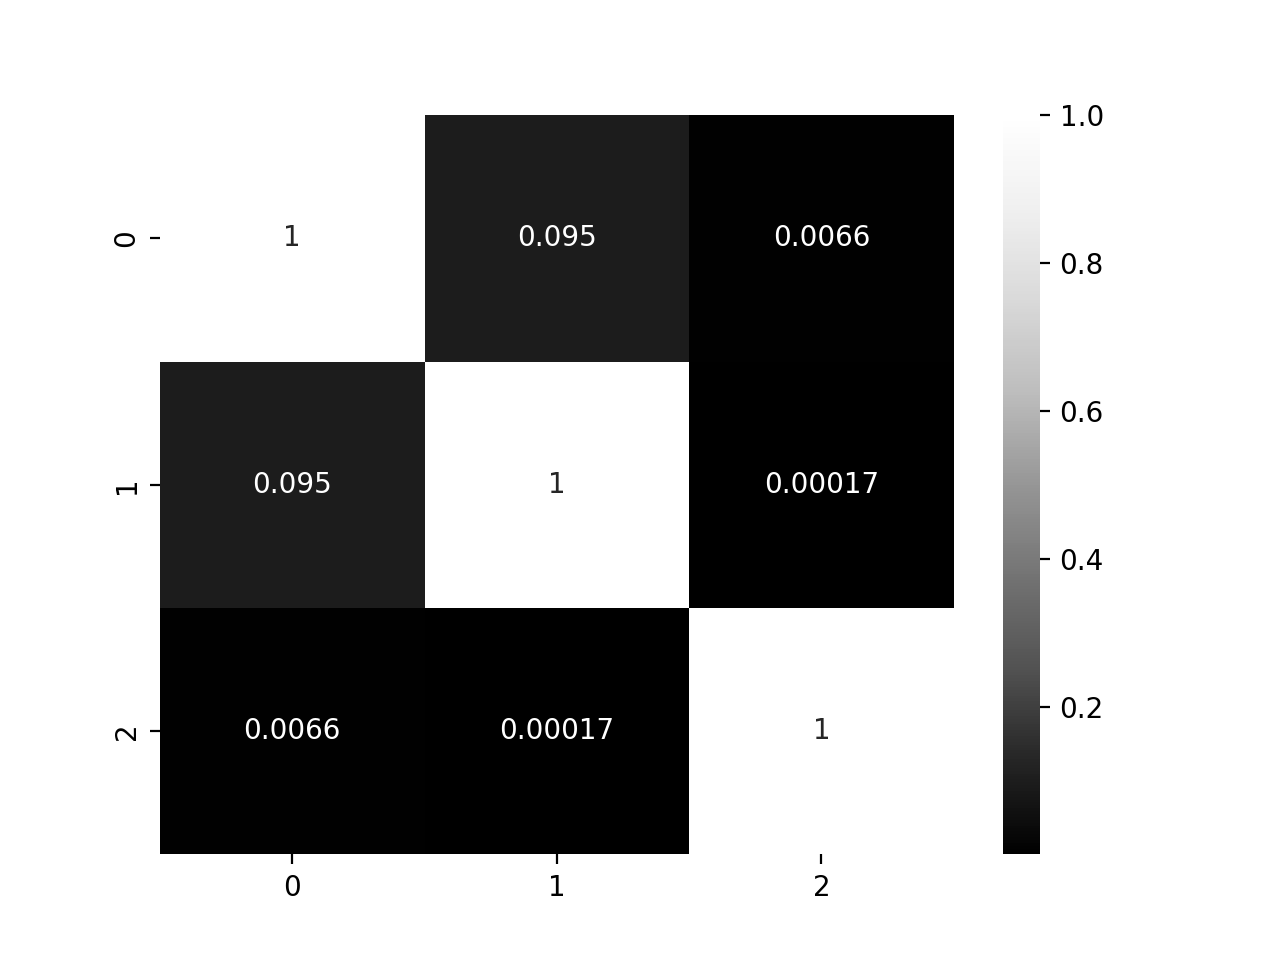

3


NameError: name 'Matrix' is not defined

In [110]:
def get_dataset(n):
    X,Y = sklearn.datasets.make_classification(n_samples=n,shuffle=False,
                                           n_features=2,
                                           n_informative=2,
                                           n_redundant=0,
                                           n_repeated=0,
                                           n_clusters_per_class =1,
                                           class_sep = 3,
                                           random_state=1,
                                          )

    noise = np.random.uniform(0,1,size=(n,1))
    X = np.concatenate([X,noise],axis=1)
    return X,Y

X,Y = get_dataset(int(1e+3))
features = pd.DataFrame(X)
plt.figure()
sns.heatmap(features.corr(method ='pearson').abs(), annot=True, cmap=plt.cm.Greys_r)
plt.show()
print(np.linalg.matrix_rank(X, tol=1e-3))
_, inds = Matrix(x).rref(iszerofunc=lambda x: abs(x)<1e-3)
inds

[0.93817392 0.05378549]
[98.24296279 23.52297897]


<IPython.core.display.Javascript object>


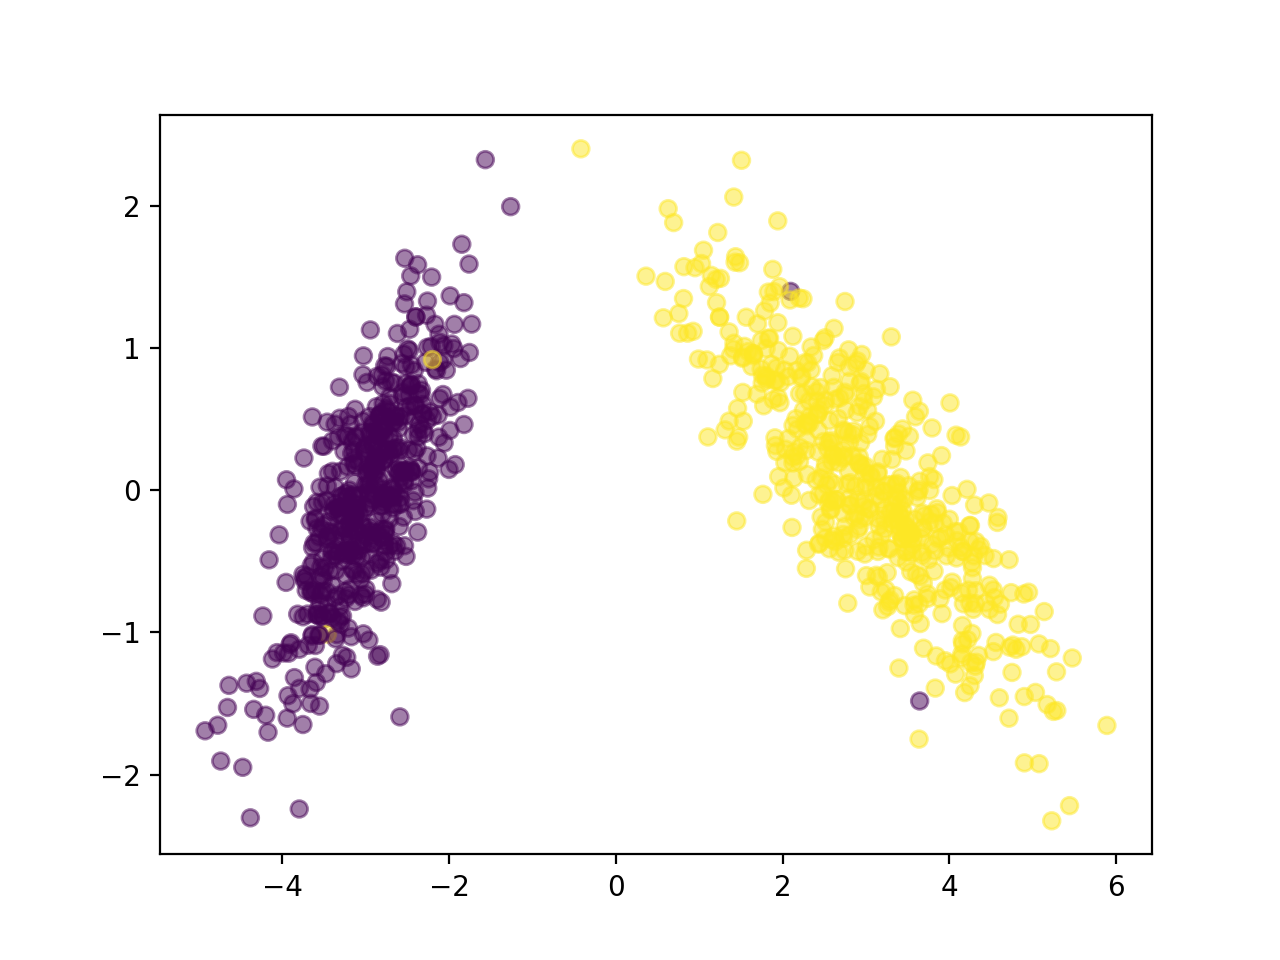

In [111]:
pca = PCA(n_components=2)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)
reduced = pca.transform(X)
plt.figure()
plt.scatter(reduced[:,0],reduced[:,1],c=Y,alpha=0.5)
plt.show()

In [112]:
class Net(torch.nn.Module):
    def __init__(self,n):
        super().__init__()
        self.activation = torch.nn.Sigmoid()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n,4),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(4),
            torch.nn.Linear(4,2),
        )
    def forward(self,x):
        out = self.model(x)
        out = torch.softmax(out,1)
        return out

In [119]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = torch.Tensor(X)
        self.Y = torch.Tensor(Y)
        
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]
    
    def __len__(self):
        return self.X.shape[0]

size = int(1e+6)
X,Y = get_dataset(size)
dataset = Dataset(X,Y)

ratio = 0.3
val_size = int(ratio*len(dataset))
dataset_train,dataset_val = torch.utils.data.random_split(dataset,[size-val_size,val_size])

batch_size=128
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=batch_size,shuffle=True)

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


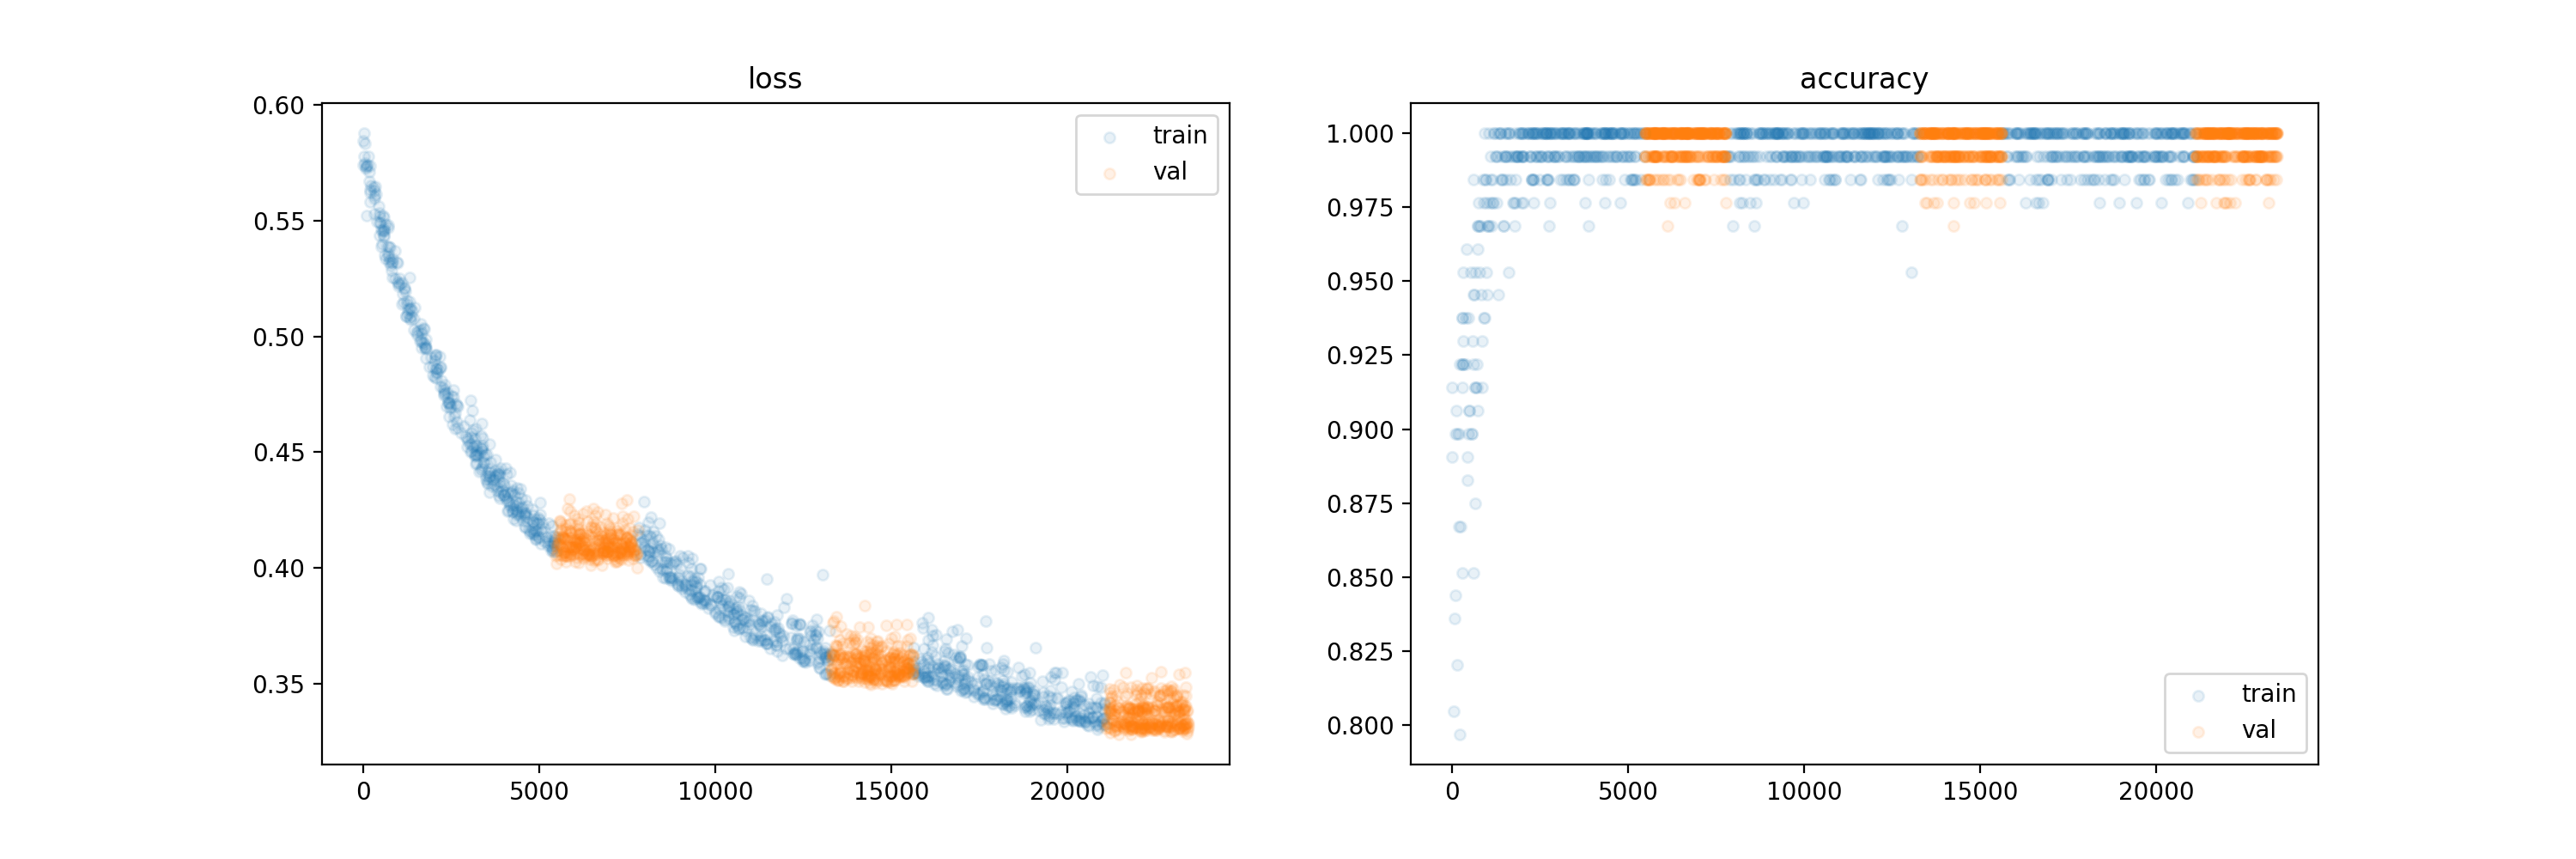

In [120]:
from track import Tracker

tracker = Tracker(2)

model = Net(X.shape[1])

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 2e-5)

model.train()
iteration = 0
for epoch in tqdm(range(3)):
    for phase in ['train','val']:
        dataloader = dataloader_train if phase=='train' else dataloader_val
        model.train() if phase=='train' else model.eval()
        torch.set_grad_enabled(phase=='train')
        for i,(x,target) in enumerate((dataloader)):
            y = model(x)
            target = target.to(dtype=torch.long)
            loss = criterion(y,target)
            if phase=='train':
                loss.backward()
                optimizer.step()

            accuracy = torch.eq(y.argmax(1),target).to(dtype=torch.float).mean()
            tracker.record(('loss',phase),(iteration,loss.item()))
            tracker.record(('accuracy',phase),(iteration,accuracy.item()))
            if iteration%1000==0:
                tracker.update()
            iteration +=1
        tracker.update()
        

In [121]:
np.mean([_[1] for _ in tracker.history.dict['accuracy']['val'][-10:]])

0.99609375

In [122]:
from captum.attr import IntegratedGradients
from functools import partial

from typing import Any, Callable

from captum._utils.common import _format_input, _format_output, _is_tuple
from captum._utils.gradient import (
    apply_gradient_requirements,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType, TensorOrTupleOfTensorsGeneric
from captum.attr._utils.attribution import GradientAttribution
from captum.log import log_usage

class Gradient(GradientAttribution):
    
    def __init__(self, forward_func: Callable) -> None:
        GradientAttribution.__init__(self, forward_func)

    @log_usage()
    def attribute(
        self,
        inputs: TensorOrTupleOfTensorsGeneric,
        target: TargetType = None,
        additional_forward_args: Any = None,
    ) -> TensorOrTupleOfTensorsGeneric:
        
        is_inputs_tuple = _is_tuple(inputs)

        inputs = _format_input(inputs)
        gradient_mask = apply_gradient_requirements(inputs)

        gradients = self.gradient_func(self.forward_func, inputs, target, None)

        attributions = tuple(gradients)
        
        undo_gradient_requirements(inputs, gradient_mask)
        return _format_output(is_inputs_tuple, attributions)

from guided_ig import unbounded_guided_ig

class GuidedIG:
    def __init__(self,model):
        self.model = model.eval()
        self.G = Gradient(model)
        
    def attribute(self,x,baselines=None,target=None):
        attr = []
        for x,baseline in zip(x,baselines):
            baseline = baseline.unsqueeze(0).detach().numpy()
            x = x.unsqueeze(0).detach().numpy()
            a = unbounded_guided_ig(x,baseline,50,partial(self.grad_func,target),0.1)
            attr.append(a.copy())
        return torch.Tensor(np.stack(attr))
    
    def grad_func(self,target,x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x.requires_grad = True
        out = self.G.attribute(x,target=target).detach().numpy()
        return out
 

In [125]:
import copy
model.eval()
IG = IntegratedGradients(model,True)
GIG = GuidedIG(model)

means = dataset.X.mean(0)
stds = dataset.X.std(0)*0.1

dist = torch.distributions.multivariate_normal.MultivariateNormal(means, covariance_matrix=torch.diag(stds))

def get_random_baseline(n):
    return dist.sample(torch.Size([n])) 

def explain(x,target,method='ig',baseline='zero'):
    if baseline =='zero':
        baselines = torch.zeros_like(x)
    if baseline =='random': 
        baselines = get_random_baseline(20)
        x = torch.repeat_interleave(x,20,dim=0)
    if method=='ig':
        attr = IG.attribute(x,baselines=baselines,target=target)
    elif method=='gig':
        attr = GIG.attribute(x,baselines=baselines,target=target)[:,0,:]
    attr = attr.mean(0)
    return attr

baselines = ['zero','random']
methods = ['ig','gig']
A = {method:{b:[] for b in baselines}.copy() for method in methods}
T = copy.deepcopy(A)

for i,(x,y) in tqdm(list(enumerate(dataset_val))[:500]):
    x = x.unsqueeze(0)
    for target in range(2):
        for method in methods:
            for baseline in baselines:
                attr = explain(x,target,method=method,baseline=baseline)
                A[method][baseline].append(attr.numpy())
                T[method][baseline].append(target)

A = {method:{b:np.stack(val) for b,val in mathod_val.items()} for method,mathod_val in A.items()}
T = {method:{b:np.stack(val) for b,val in mathod_val.items()} for method,mathod_val in T.items()}

  0%|          | 0/500 [00:00<?, ?it/s]

In [126]:
np.save('A_small.npy',A)
np.save('T_small.npy',T)

<IPython.core.display.Javascript object>


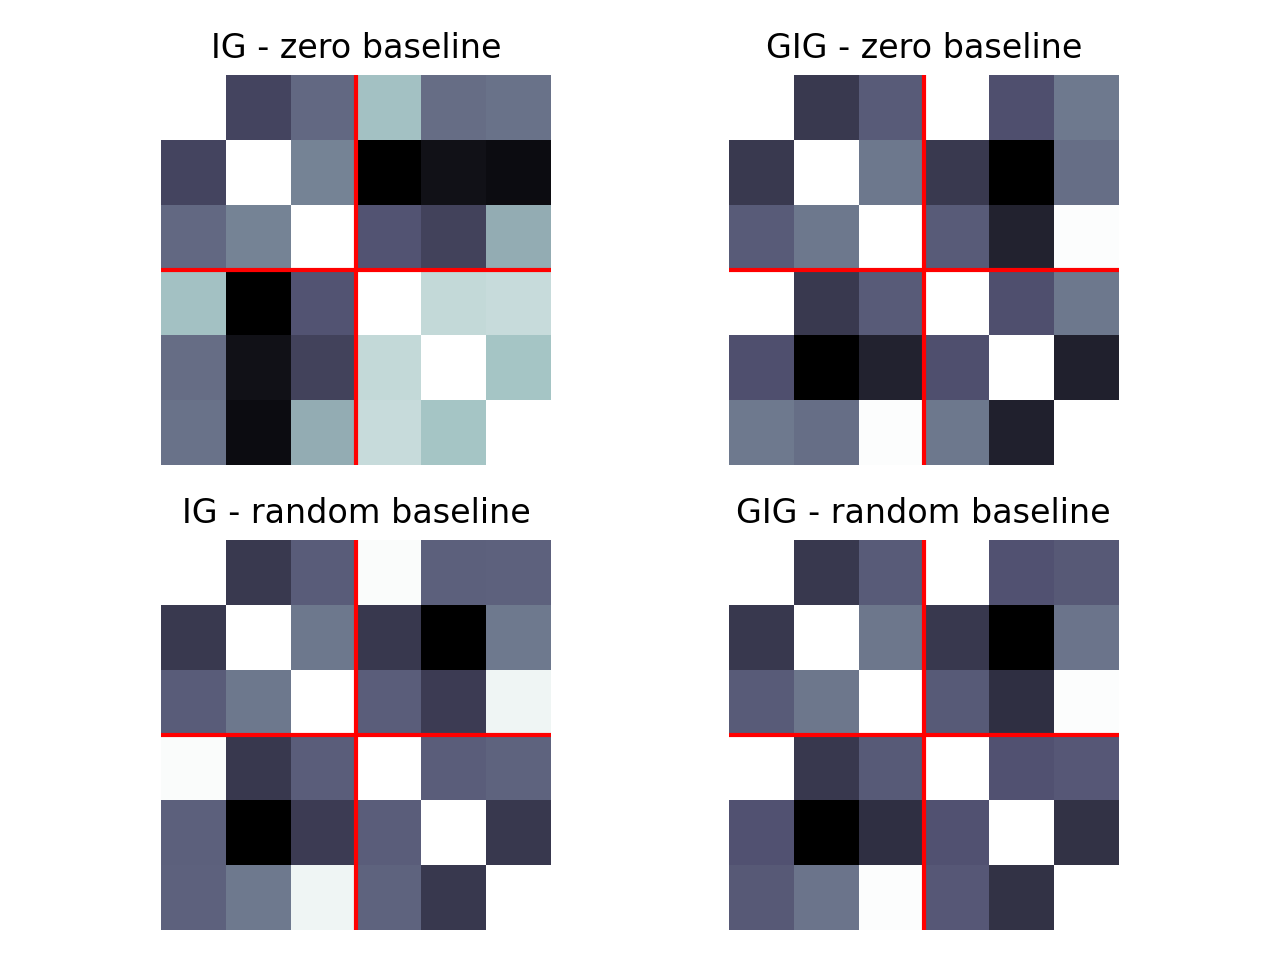

In [158]:
import scipy.stats

fig,ax = plt.subplots(len(baselines),len(methods),squeeze=False,sharex=True,sharey=True)
for i,method in enumerate(methods):
    for j,baseline in enumerate(baselines):
        x = A[method][baseline][T[method][baseline]==1,:]
        y = dataset_val[:500][0]
#         corr = np.corrcoef(y, y=x, rowvar=False)[3:,:3]
        corr = scipy.stats.spearmanr(y, b=x, axis=0).correlation
        sns.heatmap(corr, annot=False, cmap='bone',ax=ax[j,i],cbar=False,square=True)
        ax[j,i].axvline(3, 0, 1, color='red')
        ax[j,i].axhline(3, 0, 1, color='red')
#         ax[j,i].imshow(corr,alpha=0.5,cmap='cool')
        ax[j,i].set_title(f'{method.upper()} - {baseline} baseline')
        ax[j,i].axis('off')
plt.tight_layout()
plt.savefig('corr_topright_small.pdf')
plt.show()     

<IPython.core.display.Javascript object>


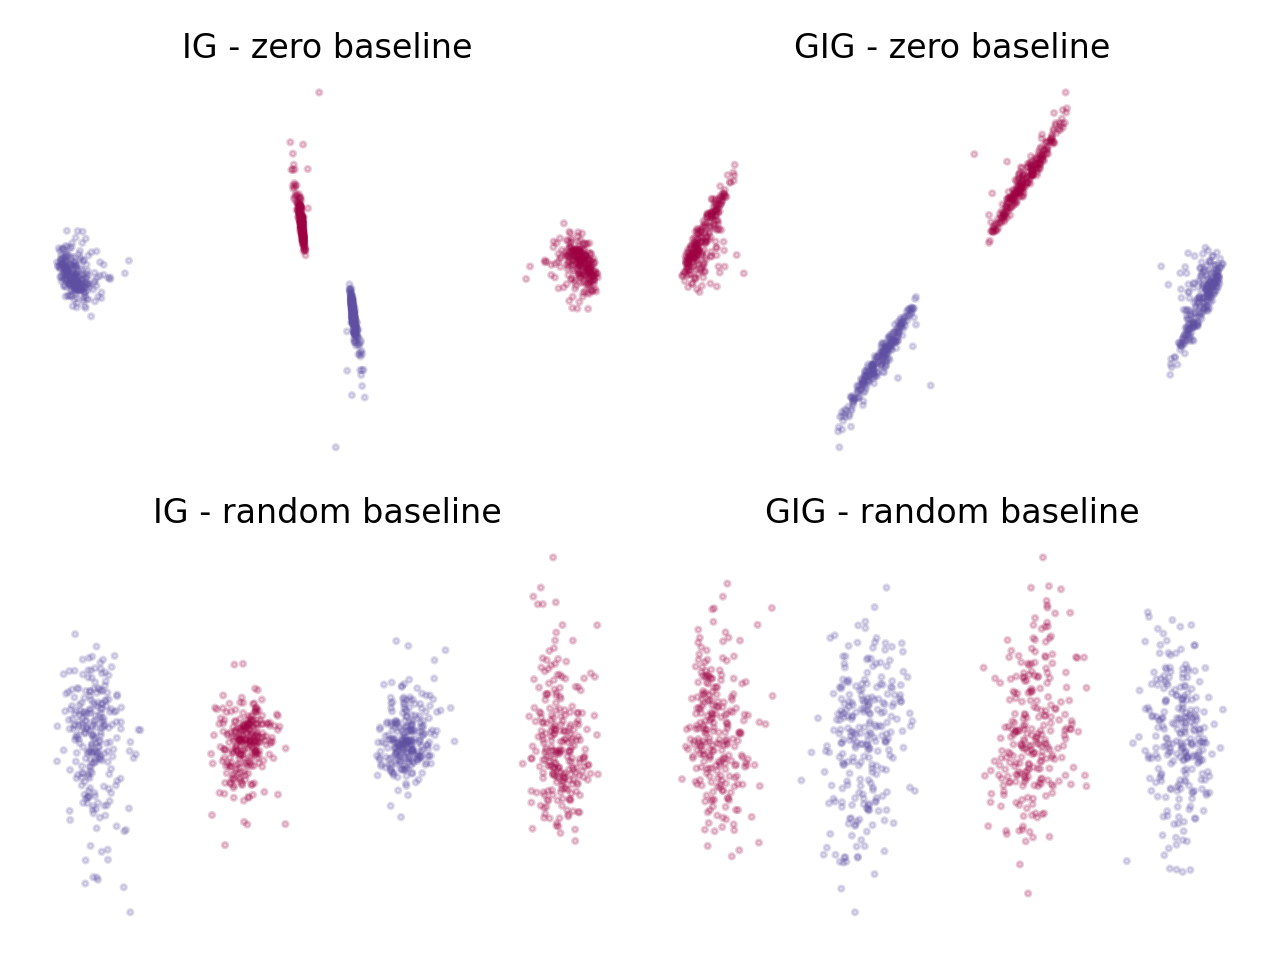

In [135]:
fig,ax = plt.subplots(len(baselines),len(methods),squeeze=False)
for i,method in enumerate(methods):
    for j,baseline in enumerate(baselines):
        pca = PCA(n_components=2)
        reduced = pca.fit(A[method][baseline])
        reduced = pca.transform(A[method][baseline])
        ax[j,i].scatter(reduced[:,0],reduced[:,1],c=T[method][baseline],alpha=0.2,cmap='Spectral',s=4)
        ax[j,i].set_title(f'{method.upper()} - {baseline} baseline')
        ax[j,i].axis('off')

plt.tight_layout() 
plt.savefig('pca_small.pdf')
plt.show()

<IPython.core.display.Javascript object>


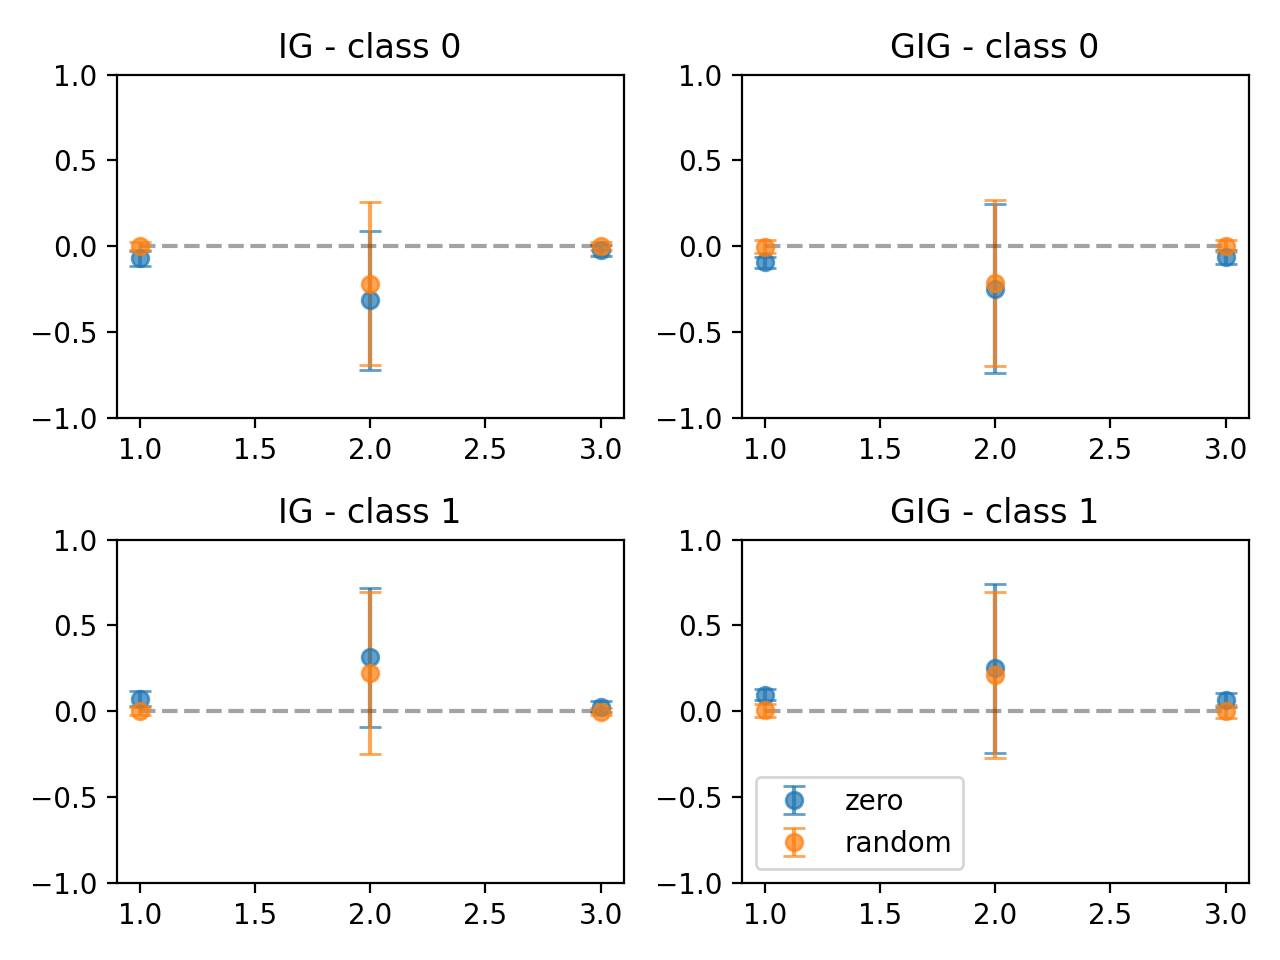

In [136]:
fig,ax = plt.subplots(2,len(methods),squeeze=False)
for baseline in baselines:

    for i,method in enumerate(methods):
        for j,target in enumerate(range(2)):
            attributions = A[method][baseline].copy()
            attributions = attributions[T[method][baseline]==target,:]

            ax[j,i].errorbar(range(1,3+1), attributions.mean(0),
                             yerr=attributions.std(0),
                             fmt='o',capthick=1,capsize=4,
                            label = baseline,
                            alpha=0.7)
            ax[j,i].set_title(f'{method.upper()} - class {target}')
            ax[j,i].set_ylim(-1,1)
            ax[j,i].plot(range(1,3+1),[0 for _ in range(1,3+1)],'--k',alpha=0.2)
#         ax[j,i].axis('off')
# fig.title(baseline)
plt.legend()
plt.tight_layout()   
plt.savefig('mean_std_small.pdf')
plt.show()

<IPython.core.display.Javascript object>


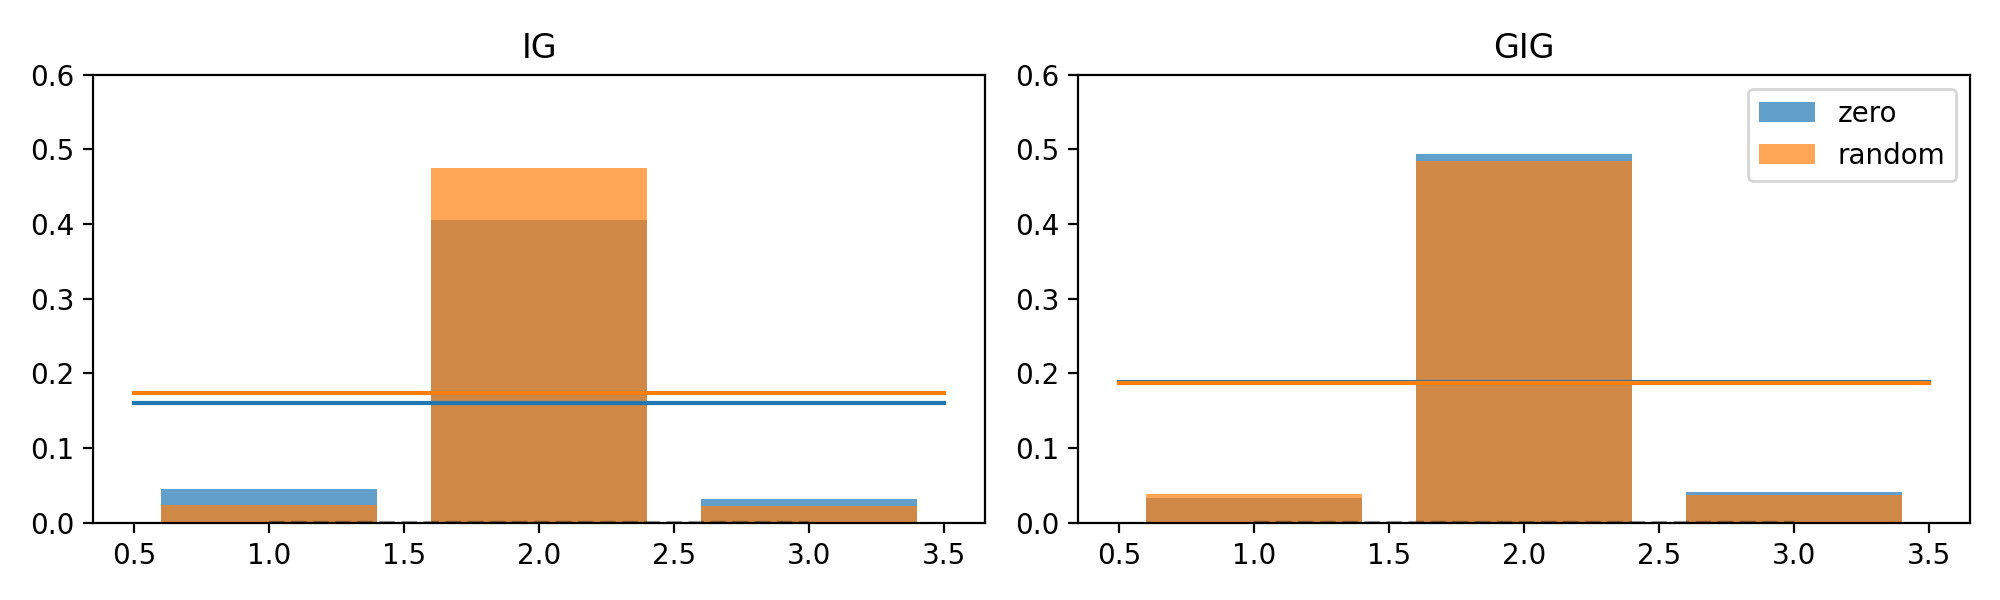

In [138]:
fig,ax = plt.subplots(1,len(methods),squeeze=False,figsize=(10,3))
for baseline in baselines:

    for i,method in enumerate(methods):
        for j,target in enumerate(range(1)):
            attributions = A[method][baseline].copy()
            attributions = attributions[T[method][baseline]==target,:]

            ax[j,i].bar(range(1,3+1), attributions.std(0),
                            label = baseline,
                            alpha=0.7)
            ax[j,i].plot(np.linspace(0.5,3.5,3),[attributions.std(0).mean() for _ in range(1,3+1)])
            ax[j,i].set_title(f'{method.upper()}')
            ax[j,i].set_ylim(None,0.6)
            ax[j,i].plot(range(1,3+1),[0 for _ in range(1,3+1)],'--k',alpha=0.2)
#         ax[j,i].axis('off')
# fig.title(baseline)
plt.legend()
plt.tight_layout()   
plt.savefig('std_small.pdf')
plt.show()